## 다이나믹 프로그래밍
다음 환경(**GridWorldEnvironment**)을 가지고 가치 이터레이션, 정책 이터레이션을 구현하세요.

## GridWorldEnvironment
```py
start_point = (0,0)
end_point = (4,4)
gridworld_size = (5,5)
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

In [ ]:
%pip install numpy matplotlib seaborn

## Original Code

In [1]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, grid_world_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1

    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

    def state_after_action(self, state, action_idx:int):
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state

    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

## Own Code
위 환경 클래스를 상속 받아 `env.render` 코드를 구현하세요.

### 구현 설명

`render` 메서드 오버라이딩: 일부 인덱스 에러 해결 (if self.tarces 조건 추가)

`move` 메서드 추가: 에이전트 이동, 보상 반환

In [2]:
class MyGridWorldEnvironment(GridWorldEnvironment):
    def __init__(self, start_point, end_point, grid_world_size):
        super().__init__(start_point, end_point, grid_world_size)
        # 시작 위치를 traces에 추가하여 초기화
        self.traces = [start_point]
    
    def render(self):
        # 빈 그리드 생성
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()
        
        # traces가 있는 경우에만 경로 표시 (새로 추가한 로직)
        if self.traces:
            last_point = self.traces[-1]  # 에이전트가 마지막으로 있었던 위치
            traces = list(set(self.traces))
            
            # 에이전트의 경로 표시
            for trace in traces:
                self.grid_world[trace[0]][trace[1]] = "X"
            
            # 현재 에이전트 위치 표시
            self.grid_world[last_point[0]][last_point[1]] = "A"
        
        # 시작점과 목표점 표시
        self.grid_world[self.start_point[0]][self.start_point[1]] = "S"
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G"
        
        # 그리드를 문자열로 변환하여 출력
        grid = ""
        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j] + " "
            grid += "\n"
        
        print(grid)
    
    def move(self, action_idx): # Move: 새로 추가된 기능
        if not self.traces:
            current_state = self.start_point
        else:
            current_state = self.traces[-1]
        
        next_state = self.state_after_action(current_state, action_idx)
        self.traces.append(next_state)
        
        return next_state, self.get_reward(current_state, action_idx)

# 01. 정책 이터레이션
- 스켈레톤 코드  
`init` 부분를 제외한 나머지 메소드를 채워주세요.

In [3]:
class PolicyIteration:
    def __init__(self,env):
        # about env
        self.env = env
        self.action_space = env.action_space # ['up', 'down', 'left', 'right'] 차례대로 (-1,0) (1,0) (0,-1) (0,1)
        self.num_action = len(self.action_space)

        # value 2d list
        self.value_table = np.zeros(shape = (env.height, env.width)).tolist() # Appendix 1

        # 상하좌우 동일한 확률을 가지는 정책으로 초기화
        self.policy_table = np.full(shape = (env.height, env.width, self.num_action), fill_value = 1/self.num_action).tolist()

        # end state 에서는 어떠한 행동도 할 필요가 없어서 policy table을 비운다.
        self.policy_table[env.end_point[0]][env.end_point[1]] = []

        self.gamma = 0.9 # 할인율

    def get_policy(self, state): # 특정 상태에서의 정책 반환
        row, col = state
        return self.policy_table[row][col]

    def get_value(self, state): # 특정 상태의 가치 반환
        row, col = state
        return self.value_table[row][col]

    def get_action(self,state): # 정책에 따라 액션 선택
        # 목표 지점에 도달한 경우 종료
        if state == self.env.end_point:
            return None
        
        # 현재 정책에 따라 액션 확률 분포에서 액션 선택
        policy = self.get_policy(state)
        action_idx = np.random.choice(range(self.num_action), p=policy)
        return action_idx

    def policy_evaluation(self): # 정책 평가: 현재 정책 하에서 각 상태의 가치 계산
        # 가치 함수 수렴 여부를 확인하기 위한 임계값
        threshold = 1e-4
        
        # 가치 함수가 수렴할 때까지 반복
        while True:
            delta = 0
            # 모든 상태에 대해 벨만 기대 방정식 적용
            for state in self.env.total_states:
                row, col = state
                
                # 목표 지점은 건너뛰기 (가치가 이미 결정됨)
                if state == self.env.end_point:
                    continue
                    
                old_value = self.value_table[row][col]
                new_value = 0
                
                # 현재 정책에 따른 모든 액션에 대해
                for action_idx in range(self.num_action):
                    action_prob = self.policy_table[row][col][action_idx]
                    # 액션을 취했을 때의 다음 상태 계산
                    next_state = self.env.state_after_action(state, action_idx)
                    reward = self.env.get_reward(state, action_idx)
                    # 벨만 기대 방정식으로 가치 업데이트
                    next_value = self.get_value(next_state)
                    new_value += action_prob * (reward + self.gamma * next_value)
                
                # 가치 테이블 업데이트
                self.value_table[row][col] = new_value
                
                # 가치 변화량 계산
                delta = max(delta, abs(old_value - new_value))
            
            # 가치 함수가 충분히 수렴하면 종료
            if delta < threshold:
                break
                
        return self.value_table

    def policy_improvement(self): # 정책 개선: 계산된 가치를 바탕으로 정책 업데이트
        policy_changed = False
    
        # 모든 상태에 대해
        for state in self.env.total_states:
            row, col = state
            
            # 목표 지점은 건너뛰기
            if state == self.env.end_point:
                continue
                
            # 현재 정책에서 최고 확률을 가진 액션
            old_action = np.argmax(self.policy_table[row][col])
            
            # 각 액션의 가치 계산
            action_values = []
            for action_idx in range(self.num_action):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                # Q 값 계산: 즉각적 보상 + 감가된 다음 상태 가치
                action_values.append(reward + self.gamma * next_value)
            
            # 가장 높은 가치를 주는 액션 선택
            new_action = np.argmax(action_values)
            
            # 정책 업데이트 - 최적 액션에 100% 확률 부여(Greedy 정책)
            self.policy_table[row][col] = [0.0] * self.num_action
            self.policy_table[row][col][new_action] = 1.0
            
            # 정책 변화 확인
            if old_action != new_action:
                policy_changed = True
                
        return policy_changed

## 정책 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [4]:
# 환경 초기화
start_point = (0, 0)
end_point = (4, 4)
gridworld_size = (5, 5)
env = MyGridWorldEnvironment(start_point, end_point, gridworld_size)

# 정책 이터레이션 객체 생성
pi = PolicyIteration(env)

# 정책 이터레이션 실행 및 과정 추적
print("정책 이터레이션 시작")
iteration_count = 0
value_history = []  # 가치 함수 변화 기록

while True:
    # 현재 가치 함수 저장
    value_history.append(np.array(pi.value_table).copy())
    
    # 정책 평가
    pi.policy_evaluation()
    
    # 정책 개선
    policy_changed = pi.policy_improvement()
    
    # 반복 횟수 증가
    iteration_count += 1
    print(f"반복 횟수: {iteration_count}")
    
    # 가치 함수 출력 (소수점 3자리까지)
    print("현재 가치 함수:")
    for row in pi.value_table:
        print([f"{val:.3f}" for val in row])
    print()
    
    # 정책이 더 이상 변하지 않으면 종료
    if not policy_changed:
        print("정책이 수렴했습니다.")
        break
    
    # 안전 장치: 최대 10회 반복
    if iteration_count >= 10:
        print("최대 반복 횟수에 도달했습니다.")
        break

print("정책 이터레이션 완료!")

# 최종 정책 시각화
print("\n최종 정책:")
action_symbols = {0: "↑", 1: "↓", 2: "←", 3: "→"}

for i in range(env.height):
    policy_row = []
    for j in range(env.width):
        if (i, j) == env.end_point:
            policy_row.append("G")
        else:
            action_idx = np.argmax(pi.policy_table[i][j])
            policy_row.append(action_symbols[action_idx])
    print(" ".join(policy_row))

# 학습된 정책으로 에이전트 이동 시뮬레이션
print("\n학습된 정책으로 에이전트 이동 시뮬레이션:")
env = MyGridWorldEnvironment(start_point, end_point, gridworld_size)  # 환경 초기화
current_state = env.start_point

# 초기 상태 렌더링
env.render()

# 목표에 도달할 때까지 이동 (무한 루프 방지용 최대 스텝 25)
steps = 0
max_steps = 25

while current_state != env.end_point and steps < max_steps:
    # 현재 상태에서 정책에 따라 액션 선택
    action = np.argmax(pi.policy_table[current_state[0]][current_state[1]])
    
    # 환경에서 액션 실행
    next_state, reward = env.move(action)
    
    # 결과 출력
    print(f"스텝 {steps+1}: 액션={pi.action_space[action]}, 보상={reward}")
    env.render()
    
    # 상태 업데이트
    current_state = next_state
    steps += 1

# 결과 출력
if current_state == env.end_point:
    print(f"목표 달성! 총 {steps}번 이동")
else:
    print("최대 스텝 수에 도달했습니다.")

정책 이터레이션 시작
반복 횟수: 1
현재 가치 함수:
['0.025', '0.030', '0.041', '0.054', '0.064']
['0.030', '0.039', '0.057', '0.081', '0.102']
['0.041', '0.057', '0.092', '0.147', '0.206']
['0.054', '0.081', '0.147', '0.274', '0.462']
['0.064', '0.102', '0.206', '0.462', '0.000']

반복 횟수: 2
현재 가치 함수:
['0.478', '0.531', '0.590', '0.656', '0.729']
['0.531', '0.590', '0.656', '0.729', '0.810']
['0.590', '0.656', '0.729', '0.810', '0.900']
['0.656', '0.729', '0.810', '0.900', '1.000']
['0.729', '0.810', '0.900', '1.000', '0.000']

반복 횟수: 3
현재 가치 함수:
['0.478', '0.531', '0.590', '0.656', '0.729']
['0.531', '0.590', '0.656', '0.729', '0.810']
['0.590', '0.656', '0.729', '0.810', '0.900']
['0.656', '0.729', '0.810', '0.900', '1.000']
['0.729', '0.810', '0.900', '1.000', '0.000']

정책이 수렴했습니다.
정책 이터레이션 완료!

최종 정책:
↓ ↓ ↓ ↓ ↓
↓ ↓ ↓ ↓ ↓
↓ ↓ ↓ ↓ ↓
↓ ↓ ↓ ↓ ↓
→ → → → G

학습된 정책으로 에이전트 이동 시뮬레이션:
S . . . . 
. . . . . 
. . . . . 
. . . . . 
. . . . G 

스텝 1: 액션=down, 보상=0.0
S . . . . 
A . . . . 
. . . . . 
. . . . . 
. . . . 

## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터를 찾아 시각화해 주세요.

1. **가치 함수의 변화**: 각 반복마다 가치 함수가 얼마나 변하는지

2. **정책의 변화**: 정책이 얼마나 자주 바뀌는지

3. **수렴의 속도**: 반복 횟수에 따른 가치 함수의 수렴 정도

In [ ]:
# 필요한 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def visualize_learning_progress(value_history, vi, env):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. 반복 횟수별 가치 함수 변화량 (왼쪽 상단)
    ax1 = axes[0, 0]
    value_changes = []
    for i in range(1, len(value_history)):
        change = np.mean(np.abs(value_history[i] - value_history[i-1]))
        value_changes.append(change)
    
    ax1.plot(range(1, len(value_history)), value_changes, marker='o', color='blue')
    ax1.set_title('Average Value Function Change')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Average Change')
    ax1.grid(True)
    
    # 2. 주요 상태들의 가치 함수 변화 (오른쪽 상단)
    ax2 = axes[0, 1]
    # 시작 지점, 중간 지점, 목표 근처 지점의 가치 추적
    start_values = [vh[0, 0] for vh in value_history]
    middle_values = [vh[2, 2] for vh in value_history]
    near_goal_values = [vh[3, 3] for vh in value_history]
    
    ax2.plot(range(len(value_history)), start_values, marker='o', label='Start Position (0,0)')
    ax2.plot(range(len(value_history)), middle_values, marker='s', label='Middle Position (2,2)')
    ax2.plot(range(len(value_history)), near_goal_values, marker='^', label='Near Goal (3,3)')
    ax2.set_title('Value Changes at Key Positions')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Value')
    ax2.legend()
    ax2.grid(True)
    
    # 3. 최종 가치 함수 히트맵 (왼쪽 하단)
    ax3 = axes[1, 0]
    cmap = LinearSegmentedColormap.from_list('blue_red', ['blue', 'white', 'red'], N=100)
    final_values = value_history[-1]
    sns.heatmap(final_values, annot=True, fmt=".3f", cmap=cmap, linewidths=.5, ax=ax3)
    ax3.set_title('Final Value Function Distribution')
    
    # 4. 최적 정책 시각화 (오른쪽 하단)
    ax4 = axes[1, 1]
    
    # 그리드 그리기
    for i in range(env.height + 1):
        ax4.axhline(i, color='black', lw=1)
    for j in range(env.width + 1):
        ax4.axvline(j, color='black', lw=1)
    
    # 최적 정책 테이블 생성 및 화살표 그리기
    for i in range(env.height):
        for j in range(env.width):
            if (i, j) == env.end_point:
                continue
                
            state = (i, j)
            action_idx = vi.get_action(state)
            
            # 화살표 방향 설정
            if action_idx == 0:  # up
                dx, dy = 0, -0.3
            elif action_idx == 1:  # down
                dx, dy = 0, 0.3
            elif action_idx == 2:  # left
                dx, dy = -0.3, 0
            else:  # right
                dx, dy = 0.3, 0
                
            ax4.arrow(j + 0.5, i + 0.5, dx, dy, head_width=0.2, head_length=0.2, 
                     fc='blue', ec='blue', width=0.05)
    
    # 목표 지점 표시
    goal_i, goal_j = env.end_point
    ax4.add_patch(plt.Rectangle((goal_j, goal_i), 1, 1, fill=True, color='red', alpha=0.3))
    ax4.text(goal_j + 0.5, goal_i + 0.5, 'GOAL', ha='center', va='center')
    
    # 시작 지점 표시
    start_i, start_j = env.start_point
    ax4.add_patch(plt.Rectangle((start_j, start_i), 1, 1, fill=True, color='green', alpha=0.3))
    ax4.text(start_j + 0.5, start_i + 0.5, 'START', ha='center', va='center')
    
    # 축 설정
    ax4.set_xlim(0, env.width)
    ax4.set_ylim(env.height, 0)  # y축을 뒤집어서 (0,0)이 왼쪽 상단에 오도록
    ax4.set_xticks(np.arange(0.5, env.width, 1))
    ax4.set_yticks(np.arange(0.5, env.height, 1))
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    ax4.set_title('Optimal Policy Directions')
    
    plt.tight_layout()
    plt.suptitle('Value Iteration Learning Progress Analysis', fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

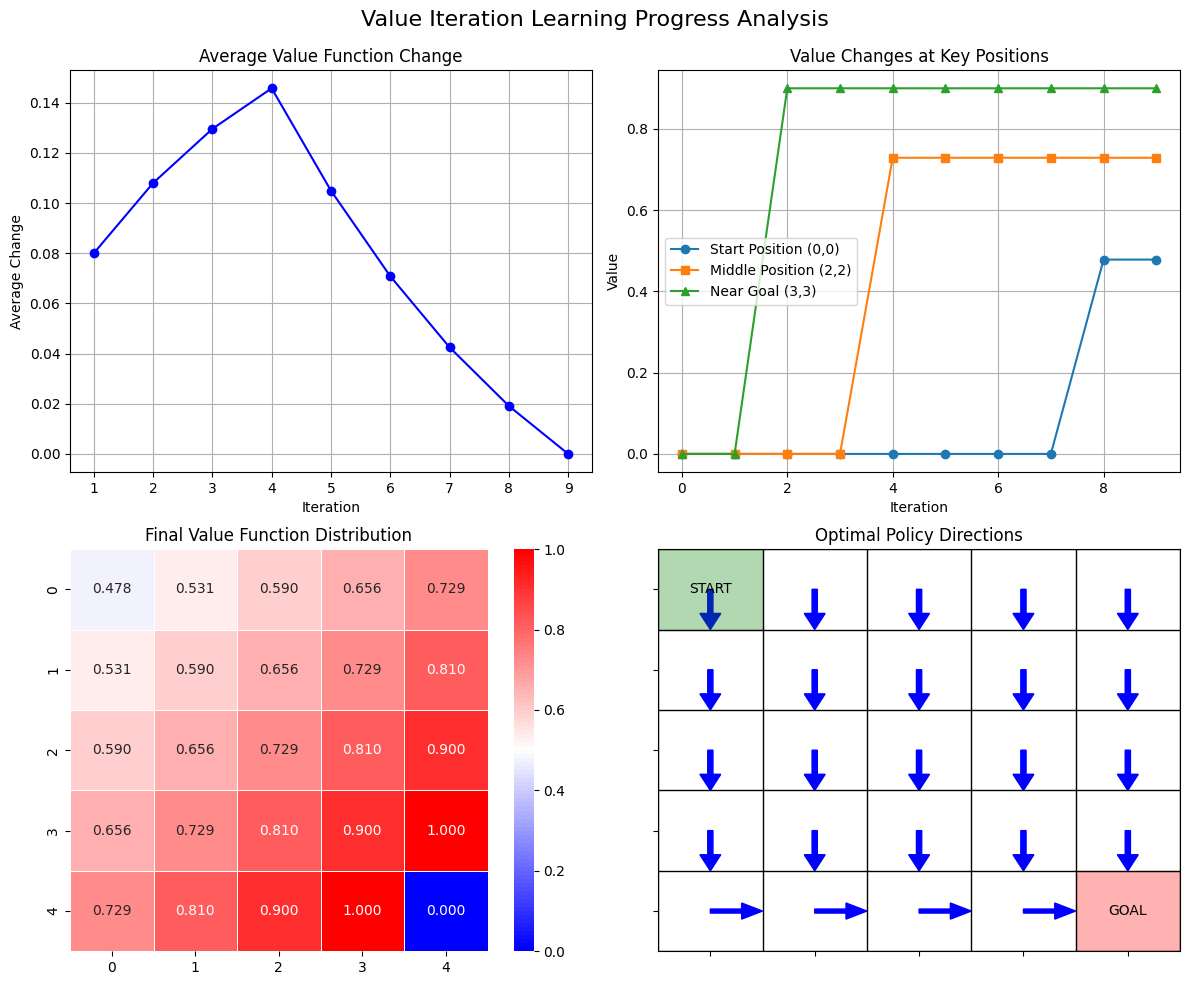

In [24]:
# 시각화 함수 호출
visualize_learning_progress(value_history, pi, env)

# 02. 가치 이터레이션
- 스켈레톤 코드  
`init` 부분를 제외한 나머지 메소드를 채워주세요.

In [18]:
class ValueIteration:
    def __init__(self, env):
        self.env = env
        self.action_space = env.action_space
        self.num_actions = env.num_actions

        # value 2d list
        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()

        self.gamma = 0.9 # 할인율

    def get_value(self, state):
        row, col = state
        return self.value_table[row][col]
        
    def get_action(self, state):
        # 목표 지점에 도달한 경우 종료
        if state == self.env.end_point:
            return None
        
        # 각 액션에 대한 가치 계산
        action_values = []
        for action_idx in range(self.num_actions):
            next_state = self.env.state_after_action(state, action_idx)
            reward = self.env.get_reward(state, action_idx)
            next_value = self.get_value(next_state)
            action_values.append(reward + self.gamma * next_value)
        
        # 최대 가치를 주는 액션 선택 (greedy)
        return np.argmax(action_values)

    def value_iteration(self):
        # 가치 함수 수렴 여부를 확인하기 위한 임계값
        threshold = 1e-4
        
        # 가치 함수 변화 기록을 위한 리스트
        value_history = [np.array(self.value_table).copy()]
        
        # 반복 횟수
        iteration_count = 0
        
        # 가치 함수가 수렴할 때까지 반복
        while True:
            delta = 0
            
            # 모든 상태에 대해 벨만 최적 방정식 적용
            for state in self.env.total_states:
                row, col = state
                
                # 목표 지점은 건너뛰기
                if state == self.env.end_point:
                    continue
                
                old_value = self.value_table[row][col]
                
                # 각 액션에 대한 가치 계산
                action_values = []
                for action_idx in range(self.num_actions):
                    next_state = self.env.state_after_action(state, action_idx)
                    reward = self.env.get_reward(state, action_idx)
                    next_value = self.get_value(next_state)
                    action_values.append(reward + self.gamma * next_value)
                
                # 최대 가치로 업데이트 (벨만 최적성 방정식)
                self.value_table[row][col] = max(action_values)
                
                # 가치 변화량 계산
                delta = max(delta, abs(old_value - self.value_table[row][col]))
            
            # 현재 가치 함수 저장
            value_history.append(np.array(self.value_table).copy())
            
            # 반복 횟수 증가
            iteration_count += 1
            print(f"반복 횟수: {iteration_count}")
            
            # 가치 함수 출력 (소수점 3자리까지)
            print("현재 가치 함수:")
            for row in self.value_table:
                print([f"{val:.3f}" for val in row])
            print()
            
            # 가치 함수가 충분히 수렴하면 종료
            if delta < threshold:
                print(f"가치 함수가 수렴했습니다.")
                break
            
            # 안전 장치: 최대 20회 반복
            if iteration_count >= 20:
                print("최대 반복 횟수에 도달했습니다.")
                break
        
        return value_history

## 가치 이터레이션 실행
정의한 클래스를 이용해 가치 이터레이션을 실행해 주세요.

In [19]:
# 환경 초기화
start_point = (0, 0)
end_point = (4, 4)
gridworld_size = (5, 5)
env = MyGridWorldEnvironment(start_point, end_point, gridworld_size)

# 가치 이터레이션 객체 생성
vi = ValueIteration(env)

# 가치 이터레이션 실행
print("가치 이터레이션 시작")
value_history = vi.value_iteration()

print("가치 이터레이션 완료!")

# 최종 가치 함수 시각화
print("\n최종 가치 함수:")
for row in vi.value_table:
    print([f"{val:.3f}" for val in row])

# 도출된 최적 정책 시각화
print("\n도출된 최적 정책:")
action_symbols = {0: "↑", 1: "↓", 2: "←", 3: "→"}

# 각 상태에서 최적 액션 계산
optimal_policy = []
for i in range(env.height):
    policy_row = []
    for j in range(env.width):
        if (i, j) == env.end_point:
            policy_row.append("G")
        else:
            # 현재 가치 함수를 기반으로 최적 액션 계산
            state = (i, j)
            action_idx = vi.get_action(state)
            policy_row.append(action_symbols[action_idx])
    optimal_policy.append(policy_row)
    print(" ".join(policy_row))

# 학습된 정책으로 에이전트 이동 시뮬레이션
print("\n학습된 정책으로 에이전트 이동 시뮬레이션:")
env = MyGridWorldEnvironment(start_point, end_point, gridworld_size)  # 환경 초기화
current_state = env.start_point

# 초기 상태 렌더링
env.render()

# 목표에 도달할 때까지 이동 (무한 루프 방지용 최대 스텝 25)
steps = 0
max_steps = 25

while current_state != env.end_point and steps < max_steps:
    # 현재 상태에서 최적 액션 선택
    action = vi.get_action(current_state)
    
    # 환경에서 액션 실행
    next_state, reward = env.move(action)
    
    # 결과 출력
    print(f"스텝 {steps+1}: 액션={vi.action_space[action]}, 보상={reward}")
    env.render()
    
    # 상태 업데이트
    current_state = next_state
    steps += 1

# 결과 출력
if current_state == env.end_point:
    print(f"목표 달성! 총 {steps}번 이동")
else:
    print("최대 스텝 수에 도달했습니다.")

가치 이터레이션 시작
반복 횟수: 1
현재 가치 함수:
['0.000', '0.000', '0.000', '0.000', '0.000']
['0.000', '0.000', '0.000', '0.000', '0.000']
['0.000', '0.000', '0.000', '0.000', '0.000']
['0.000', '0.000', '0.000', '0.000', '1.000']
['0.000', '0.000', '0.000', '1.000', '0.000']

반복 횟수: 2
현재 가치 함수:
['0.000', '0.000', '0.000', '0.000', '0.000']
['0.000', '0.000', '0.000', '0.000', '0.000']
['0.000', '0.000', '0.000', '0.000', '0.900']
['0.000', '0.000', '0.000', '0.900', '1.000']
['0.000', '0.000', '0.900', '1.000', '0.000']

반복 횟수: 3
현재 가치 함수:
['0.000', '0.000', '0.000', '0.000', '0.000']
['0.000', '0.000', '0.000', '0.000', '0.810']
['0.000', '0.000', '0.000', '0.810', '0.900']
['0.000', '0.000', '0.810', '0.900', '1.000']
['0.000', '0.810', '0.900', '1.000', '0.000']

반복 횟수: 4
현재 가치 함수:
['0.000', '0.000', '0.000', '0.000', '0.729']
['0.000', '0.000', '0.000', '0.729', '0.810']
['0.000', '0.000', '0.729', '0.810', '0.900']
['0.000', '0.729', '0.810', '0.900', '1.000']
['0.729', '0.810', '0.900', '1.000'

## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터/요소를 찾아 시각화해 주세요.

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

def visualize_value_iteration_learning(value_history, vi, env):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. 반복 횟수별 가치 함수 변화량 (왼쪽 상단)
    ax1 = axes[0, 0]
    value_changes = []
    for i in range(1, len(value_history)):
        change = np.mean(np.abs(value_history[i] - value_history[i-1]))
        value_changes.append(change)
    
    ax1.plot(range(1, len(value_history)), value_changes, marker='o', color='blue')
    ax1.set_title('Average Value Function Change')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Average Change')
    ax1.grid(True)
    
    # 2. 특정 상태들의 가치 함수 변화 추적 (오른쪽 상단)
    ax2 = axes[0, 1]
    # 시작 지점, 중간 지점, 목표 근처 지점의 가치 추적
    start_values = [vh[0, 0] for vh in value_history]
    middle_values = [vh[2, 2] for vh in value_history]
    near_goal_values = [vh[3, 3] for vh in value_history]
    
    ax2.plot(range(len(value_history)), start_values, marker='o', label='Start Position (0,0)')
    ax2.plot(range(len(value_history)), middle_values, marker='s', label='Middle Position (2,2)')
    ax2.plot(range(len(value_history)), near_goal_values, marker='^', label='Near Goal (3,3)')
    ax2.set_title('Value Changes at Key Positions')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Value')
    ax2.legend()
    ax2.grid(True)
    
    # 3. 최종 가치 함수 히트맵 (왼쪽 하단)
    ax3 = axes[1, 0]
    cmap = LinearSegmentedColormap.from_list('blue_red', ['blue', 'white', 'red'], N=100)
    final_values = value_history[-1]
    sns.heatmap(final_values, annot=True, fmt=".3f", cmap=cmap, linewidths=.5, ax=ax3)
    ax3.set_title('Final Value Function Distribution')
    
    # 4. 최적 정책 시각화 (오른쪽 하단)
    ax4 = axes[1, 1]
    
    # 그리드 그리기
    for i in range(env.height + 1):
        ax4.axhline(i, color='black', lw=1)
    for j in range(env.width + 1):
        ax4.axvline(j, color='black', lw=1)
    
    # 최적 정책 화살표 그리기
    for i in range(env.height):
        for j in range(env.width):
            if (i, j) == env.end_point:
                continue
                
            state = (i, j)
            action_idx = vi.get_action(state)
            
            # 화살표 방향 설정
            if action_idx == 0:  # up
                dx, dy = 0, -0.3
            elif action_idx == 1:  # down
                dx, dy = 0, 0.3
            elif action_idx == 2:  # left
                dx, dy = -0.3, 0
            else:  # right
                dx, dy = 0.3, 0
                
            ax4.arrow(j + 0.5, i + 0.5, dx, dy, head_width=0.2, head_length=0.2, 
                     fc='blue', ec='blue', width=0.05)
    
    # 목표 지점 표시
    goal_i, goal_j = env.end_point
    ax4.add_patch(plt.Rectangle((goal_j, goal_i), 1, 1, fill=True, color='red', alpha=0.3))
    ax4.text(goal_j + 0.5, goal_i + 0.5, 'GOAL', ha='center', va='center')
    
    # 시작 지점 표시
    start_i, start_j = env.start_point
    ax4.add_patch(plt.Rectangle((start_j, start_i), 1, 1, fill=True, color='green', alpha=0.3))
    ax4.text(start_j + 0.5, start_i + 0.5, 'START', ha='center', va='center')
    
    # 축 설정
    ax4.set_xlim(0, env.width)
    ax4.set_ylim(env.height, 0)  # y축을 뒤집어서 (0,0)이 왼쪽 상단에 오도록
    ax4.set_xticks(np.arange(0.5, env.width, 1))
    ax4.set_yticks(np.arange(0.5, env.height, 1))
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    ax4.set_title('Optimal Policy Directions')
    
    plt.tight_layout()
    plt.suptitle('Value Iteration Learning Progress Analysis', fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

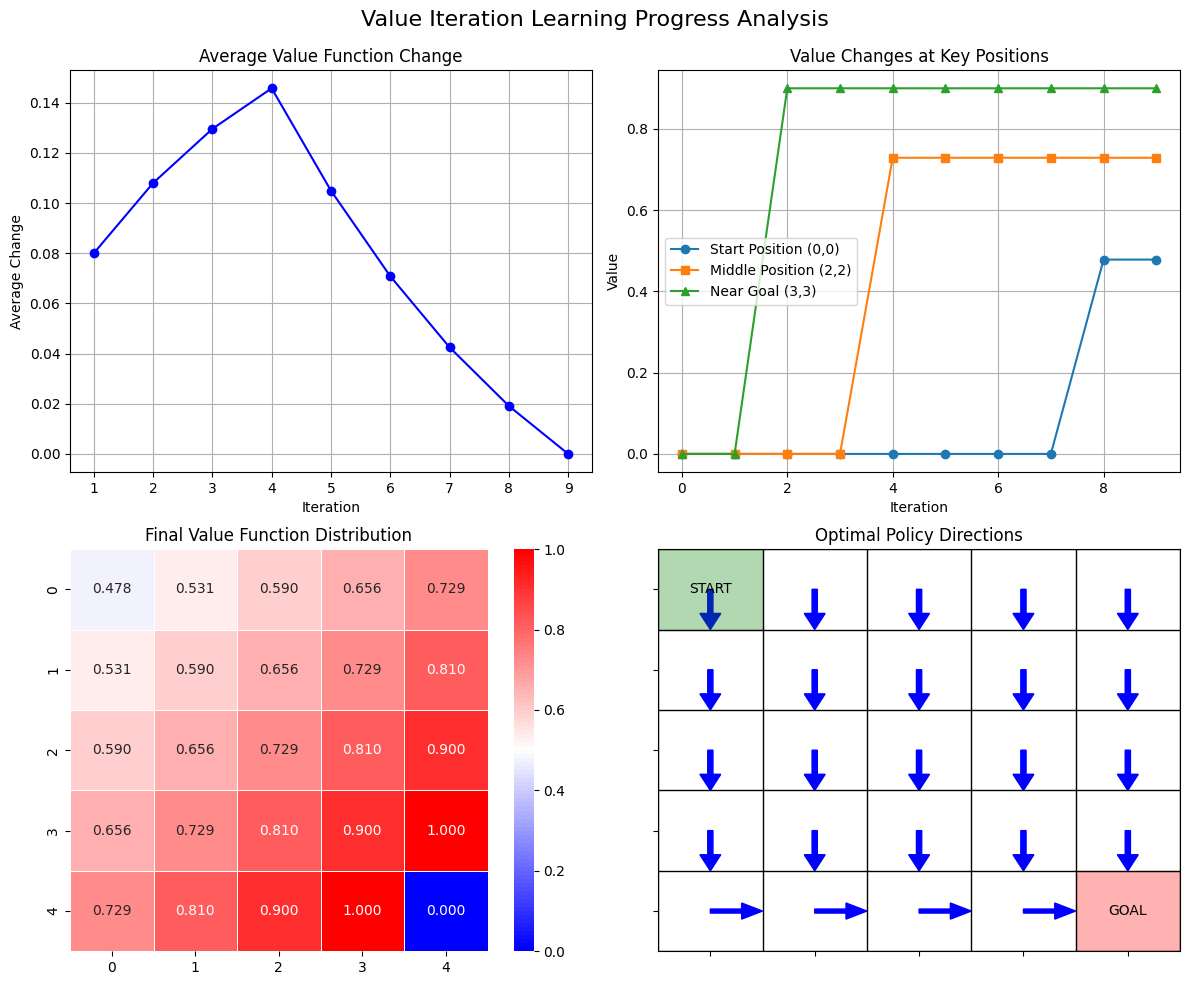

In [43]:
# 시각화 함수 호출
visualize_value_iteration_learning(value_history, vi, env)